# Kịch bản 01: Drift Toàn Cục - Chứng Minh IDS Suy Giảm

---

## Mục tiêu
Chứng minh **Concept Drift là có thật** bằng cách đo lường sự suy giảm hiệu năng của mô hình IDS tĩnh (Static Random Forest) khi triển khai từ môi trường phòng lab (Train) sang môi trường mạng thật (Test).

## Cấu hình
- **Model**: Random Forest (scikit-learn) - Static Baseline
- **Training**: Toàn bộ KDDTrain+ (125,973 mẫu) - 1 lần duy nhất (Offline)
- **Testing**: Toàn bộ KDDTest+ (22,544 mẫu)
- **Classes**: 5 categories (Normal, DoS, Probe, R2L, U2R)

## Drift Factors
1. **Label Shift**: Class distribution thay đổi (Normal 53%→43%, R2L 0.79%→12.2%)
2. **Covariate Shift**: Feature distribution thay đổi (62.5% features có drift >10%)
3. **New Concept**: 17 zero-day attacks trong Test

## Expected Outcome
Model sẽ bị suy giảm hiệu năng đáng kể, chứng minh cần giải pháp thích nghi (Kịch bản 02).

## 1. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
np.random.seed(42)

## 2. Data Loading & Preprocessing

In [2]:
# Data paths
data_dir = Path(r'H:\tdc_window\Workspace\Testspace\ids\exp_data')
train_file = data_dir / 'KDDTrain+.txt'
test_file = data_dir / 'KDDTest+.txt'

# Column names (NSL-KDD 41 features + attack_type, difficulty)
standard_column_names = [
    # Intrinsic (1-9)
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    # Content (10-22)
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    # Time-based (23-31)
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    # Host-based (32-41)
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    # Label + Difficulty
    'attack_type', 'difficulty'
]

# Attack categories mapping (Group -> list of sub-attacks or single value)
attack_categories = {
    'Normal': 'normal',
    'DoS': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'mailbomb', 'apache2', 'processtable', 'udpstorm'],
    'Probe': ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint'],
    'R2L': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'sendmail', 'named', 'snmpgetattack', 'snmpguess', 'xlock', 'xsnoop', 'worm'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'httptunnel', 'ps', 'sqlattack', 'xterm']
}

def load_and_process_data(file_path, cols, mapping_dict, drop_difficulty=False):
    """Đọc NSL-KDD, map attack_type -> label (nhóm). Strip/rstrip attack_type trước khi map."""
    df = pd.read_csv(file_path, names=cols)
    df['attack_type'] = df['attack_type'].astype(str).str.strip().str.rstrip('.')
    reversed_mapping = {}
    for group, value in mapping_dict.items():
        if isinstance(value, list):
            for sub in value:
                reversed_mapping[sub] = group
        else:
            reversed_mapping[value] = group
    df['label'] = df['attack_type'].map(reversed_mapping)
    df['label'] = df['label'].fillna('Unknown')
    if drop_difficulty:
        df = df.drop(columns=['difficulty'], errors='ignore')
    return df


In [3]:
train_df = load_and_process_data(train_file, standard_column_names, attack_categories)
test_df = load_and_process_data(test_file, standard_column_names, attack_categories)

print("TRAIN - value_counts(label)")
print(train_df['label'].value_counts())
print("\nTEST - value_counts(label)")
print(test_df['label'].value_counts())

TRAIN - value_counts(label)
label
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

TEST - value_counts(label)
label
Normal    9711
DoS       7458
R2L       2754
Probe     2421
U2R        200
Name: count, dtype: int64


## 3. Feature Engineering

In [4]:
# OneHotEncoder for categoricals (handle_unknown='ignore' for unseen services in test)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['protocol_type', 'service', 'flag']
exclude_cols = ['label', 'attack_type', 'difficulty']
X_train = train_df.drop(columns=exclude_cols)
X_test = test_df.drop(columns=exclude_cols)

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough'
)
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

label_encoder_y = LabelEncoder()
y_train = label_encoder_y.fit_transform(train_df['label'])
y_test = label_encoder_y.transform(test_df['label'])

print("X_train_encoded.shape:", X_train_encoded.shape)
print("X_test_encoded.shape:", X_test_encoded.shape)

X_train_encoded.shape: (125973, 122)
X_test_encoded.shape: (22544, 122)


In [5]:
# Use encoded features (no scaling). Downstream cells use X_train_scaled / X_test_scaled.
X_train_scaled = X_train_encoded
X_test_scaled = X_test_encoded

## 4. Train Static Random Forest Model

In [6]:
model_config = {'n_estimators': 100, 'max_depth': None, 'random_state': 42, 'n_jobs': -1}
rf_model = RandomForestClassifier(**model_config)
rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5. Evaluation - Train Set (Baseline Performance)

In [7]:
# Train set (baseline)
y_train_pred = rf_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

print("TRAIN (baseline)")
print(classification_report(y_train, y_train_pred,
                          target_names=label_encoder_y.classes_,
                          zero_division=0))

train_metrics = {
    'accuracy': train_accuracy, 'precision': train_precision, 'recall': train_recall, 'f1': train_f1,
    'confusion_matrix': confusion_matrix(y_train, y_train_pred)
}

TRAIN (baseline)
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     45927
      Normal       1.00      1.00      1.00     67343
       Probe       1.00      1.00      1.00     11656
         R2L       1.00      1.00      1.00       995
         U2R       1.00      0.98      0.99        52

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973



## 6. Evaluation - Test Set (With Drift)

In [8]:
# Test set (with drift)
y_test_pred = rf_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print("TEST (with drift)")
print(classification_report(y_test, y_test_pred,
                          target_names=label_encoder_y.classes_,
                          zero_division=0))

test_metrics = {
    'accuracy': test_accuracy, 'precision': test_precision, 'recall': test_recall, 'f1': test_f1,
    'confusion_matrix': confusion_matrix(y_test, y_test_pred)
}

TEST (with drift)
              precision    recall  f1-score   support

         DoS       0.96      0.76      0.85      7458
      Normal       0.64      0.97      0.77      9711
       Probe       0.82      0.60      0.70      2421
         R2L       0.99      0.05      0.10      2754
         U2R       0.62      0.03      0.05       200

    accuracy                           0.74     22544
   macro avg       0.81      0.48      0.49     22544
weighted avg       0.81      0.74      0.70     22544



## 7. Performance Degradation Analysis (Chứng Minh IDS Suy Giảm)

In [9]:
# Performance degradation (Train -> Test)
accuracy_drop = train_accuracy - test_accuracy
accuracy_relative_drop = (accuracy_drop / train_accuracy) * 100 if train_accuracy > 0 else 0
print("DEGRADATION (Train -> Test)")
print(f"Accuracy: {train_accuracy*100:.2f}% -> {test_accuracy*100:.2f}% (relative drop {accuracy_relative_drop:.2f}%)")
print("\nPer-class:")

# Get per-class metrics
from sklearn.metrics import recall_score, precision_score, f1_score

train_recall_per_class = recall_score(y_train, y_train_pred, average=None, zero_division=0)
test_recall_per_class = recall_score(y_test, y_test_pred, average=None, zero_division=0)

train_precision_per_class = precision_score(y_train, y_train_pred, average=None, zero_division=0)
test_precision_per_class = precision_score(y_test, y_test_pred, average=None, zero_division=0)

train_f1_per_class = f1_score(y_train, y_train_pred, average=None, zero_division=0)
test_f1_per_class = f1_score(y_test, y_test_pred, average=None, zero_division=0)

# Create comparison DataFrame
degradation_data = []
for idx, class_name in enumerate(label_encoder_y.classes_):
    recall_drop_class = train_recall_per_class[idx] - test_recall_per_class[idx]
    precision_drop_class = train_precision_per_class[idx] - test_precision_per_class[idx]
    f1_drop_class = train_f1_per_class[idx] - test_f1_per_class[idx]
    
    degradation_data.append({
        'Class': class_name,
        'Train Recall': f"{train_recall_per_class[idx]:.4f}",
        'Test Recall': f"{test_recall_per_class[idx]:.4f}",
        'Recall Drop': f"{recall_drop_class:+.4f}",
        'Train F1': f"{train_f1_per_class[idx]:.4f}",
        'Test F1': f"{test_f1_per_class[idx]:.4f}",
        'F1 Drop': f"{f1_drop_class:+.4f}"
    })

df_degradation = pd.DataFrame(degradation_data)
print(df_degradation.to_string(index=False))

# Identify worst affected classes
recall_drops = [train_recall_per_class[i] - test_recall_per_class[i] 
                for i in range(len(label_encoder_y.classes_))]
worst_class_idx = np.argmax(recall_drops)
worst_class = label_encoder_y.classes_[worst_class_idx]
worst_drop = recall_drops[worst_class_idx]

print(f"Worst affected: {worst_class} (recall drop {worst_drop*100:.2f}%)")

DEGRADATION (Train -> Test)
Accuracy: 99.99% -> 74.09% (relative drop 25.91%)

Per-class:
 Class Train Recall Test Recall Recall Drop Train F1 Test F1 F1 Drop
   DoS       1.0000      0.7570     +0.2429   0.9999  0.8469 +0.1531
Normal       0.9999      0.9731     +0.0268   0.9999  0.7730 +0.2270
 Probe       1.0000      0.6039     +0.3961   1.0000  0.6964 +0.3036
   R2L       1.0000      0.0508     +0.9492   1.0000  0.0967 +0.9033
   U2R       0.9808      0.0250     +0.9558   0.9903  0.0481 +0.9422
Worst affected: U2R (recall drop 95.58%)


## 7b. False Positive Rate (FPR) Analysis

In [10]:
# Calculate False Positive Rate from Confusion Matrix
def calculate_fpr_from_confusion_matrix(cm, class_names):
    """
    Calculate False Positive Rate for each class from confusion matrix.
    
    FPR_i = FP_i / (FP_i + TN_i)
    Where:
    - FP_i = Sum of column i (predicted as i) - diagonal (true positive)
    - TN_i = Total - (Row i sum + Column i sum - diagonal)
    
    Parameters:
    -----------
    cm : array-like, shape (n_classes, n_classes)
        Confusion matrix
    class_names : list
        List of class names
        
    Returns:
    --------
    dict : {class_name: fpr_value}
    """
    n_classes = cm.shape[0]
    fpr_dict = {}
    
    for i in range(n_classes):
        # False Positives: predicted as class i but actually not
        fp = cm[:, i].sum() - cm[i, i]
        
        # True Negatives: not class i and not predicted as class i
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        
        # FPR = FP / (FP + TN)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fpr_dict[class_names[i]] = fpr
    
    return fpr_dict

# FPR analysis

# Calculate FPR for Train set
cm_train = train_metrics['confusion_matrix']
fpr_train_dict = calculate_fpr_from_confusion_matrix(cm_train, label_encoder_y.classes_)

print("FPR Train:")
for class_name, fpr_val in fpr_train_dict.items():
    print(f"  {class_name:8} : {fpr_val:.6f} ({fpr_val*100:.4f}%)")

# Calculate weighted average FPR for Train
# Weight by number of negative samples per class
fpr_train_values = []
weights_train = []
for i, class_name in enumerate(label_encoder_y.classes_):
    fpr_train_values.append(fpr_train_dict[class_name])
    # Number of negative samples = total - positive samples
    n_positive = (y_train == i).sum()
    n_negative = len(y_train) - n_positive
    weights_train.append(n_negative)

fpr_train_weighted = np.average(fpr_train_values, weights=weights_train)
print(f"\n  {'Weighted Avg':8} : {fpr_train_weighted:.6f} ({fpr_train_weighted*100:.4f}%)")

# Calculate FPR for Test set
cm_test = test_metrics['confusion_matrix']
fpr_test_dict = calculate_fpr_from_confusion_matrix(cm_test, label_encoder_y.classes_)

print("\nFPR Test:")
for class_name, fpr_val in fpr_test_dict.items():
    print(f"  {class_name:8} : {fpr_val:.6f} ({fpr_val*100:.4f}%)")

# Calculate weighted average FPR for Test
fpr_test_values = []
weights_test = []
for i, class_name in enumerate(label_encoder_y.classes_):
    fpr_test_values.append(fpr_test_dict[class_name])
    n_positive = (y_test == i).sum()
    n_negative = len(y_test) - n_positive
    weights_test.append(n_negative)

fpr_test_weighted = np.average(fpr_test_values, weights=weights_test)
print(f"\n  {'Weighted Avg':8} : {fpr_test_weighted:.6f} ({fpr_test_weighted*100:.4f}%)")

# FPR Degradation Analysis
print("\nFPR degradation:")
fpr_degradation_data = []
for class_name in label_encoder_y.classes_:
    fpr_train = fpr_train_dict[class_name]
    fpr_test = fpr_test_dict[class_name]
    fpr_change = fpr_test - fpr_train
    fpr_change_pct = (fpr_change / fpr_train * 100) if fpr_train > 0 else 0
    
    fpr_degradation_data.append({
        'Class': class_name,
        'Train FPR': f"{fpr_train:.6f}",
        'Test FPR': f"{fpr_test:.6f}",
        'FPR Change': f"{fpr_change:+.6f}",
        'Change %': f"{fpr_change_pct:+.2f}%"
    })
    
df_fpr_degradation = pd.DataFrame(fpr_degradation_data)
print(df_fpr_degradation.to_string(index=False))

# Overall FPR change
fpr_change_overall = fpr_test_weighted - fpr_train_weighted
fpr_change_overall_pct = (fpr_change_overall / fpr_train_weighted * 100) if fpr_train_weighted > 0 else 0

print(f"\n  OVERALL FPR CHANGE (Weighted Avg):")
print(f"   Train FPR: {fpr_train_weighted:.6f} ({fpr_train_weighted*100:.4f}%)")
print(f"   Test FPR:  {fpr_test_weighted:.6f} ({fpr_test_weighted*100:.4f}%)")
print(f"   FPR Change: {fpr_change_overall:+.6f} ({fpr_change_overall_pct:+.2f}%)")

# Store FPR metrics for visualization
fpr_train_per_class = [fpr_train_dict[c] for c in label_encoder_y.classes_]
fpr_test_per_class = [fpr_test_dict[c] for c in label_encoder_y.classes_]

FPR Train:
  DoS      : 0.000037 (0.0037%)
  Normal   : 0.000051 (0.0051%)
  Probe    : 0.000009 (0.0009%)
  R2L      : 0.000000 (0.0000%)
  U2R      : 0.000000 (0.0000%)

  Weighted Avg : 0.000014 (0.0014%)

FPR Test:
  DoS      : 0.015246 (1.5246%)
  Normal   : 0.412218 (41.2218%)
  Probe    : 0.015703 (1.5703%)
  R2L      : 0.000101 (0.0101%)
  U2R      : 0.000134 (0.0134%)

  Weighted Avg : 0.064773 (6.4773%)

FPR degradation:
 Class Train FPR Test FPR FPR Change    Change %
   DoS  0.000037 0.015246  +0.015208  +40579.17%
Normal  0.000051 0.412218  +0.412167 +805512.35%
 Probe  0.000009 0.015703  +0.015695 +179416.83%
   R2L  0.000000 0.000101  +0.000101      +0.00%
   U2R  0.000000 0.000134  +0.000134      +0.00%

  OVERALL FPR CHANGE (Weighted Avg):
   Train FPR: 0.000014 (0.0014%)
   Test FPR:  0.064773 (6.4773%)
   FPR Change: +0.064759 (+466168.06%)


## 7c. Visualization - Accuracy & FPR Comparison (2 Time Points)

C:\Users\tdc13\AppData\Local\Temp\ipykernel_50852\699587981.py:126: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\tdc13\AppData\Local\Temp\ipykernel_50852\699587981.py:127: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  plt.savefig('scenario01_accuracy_fpr_comparison.png', dpi=300, bbox_inches='tight')
h:\tdc_window\Workspace\Miniconda3\envs\BTQT_conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


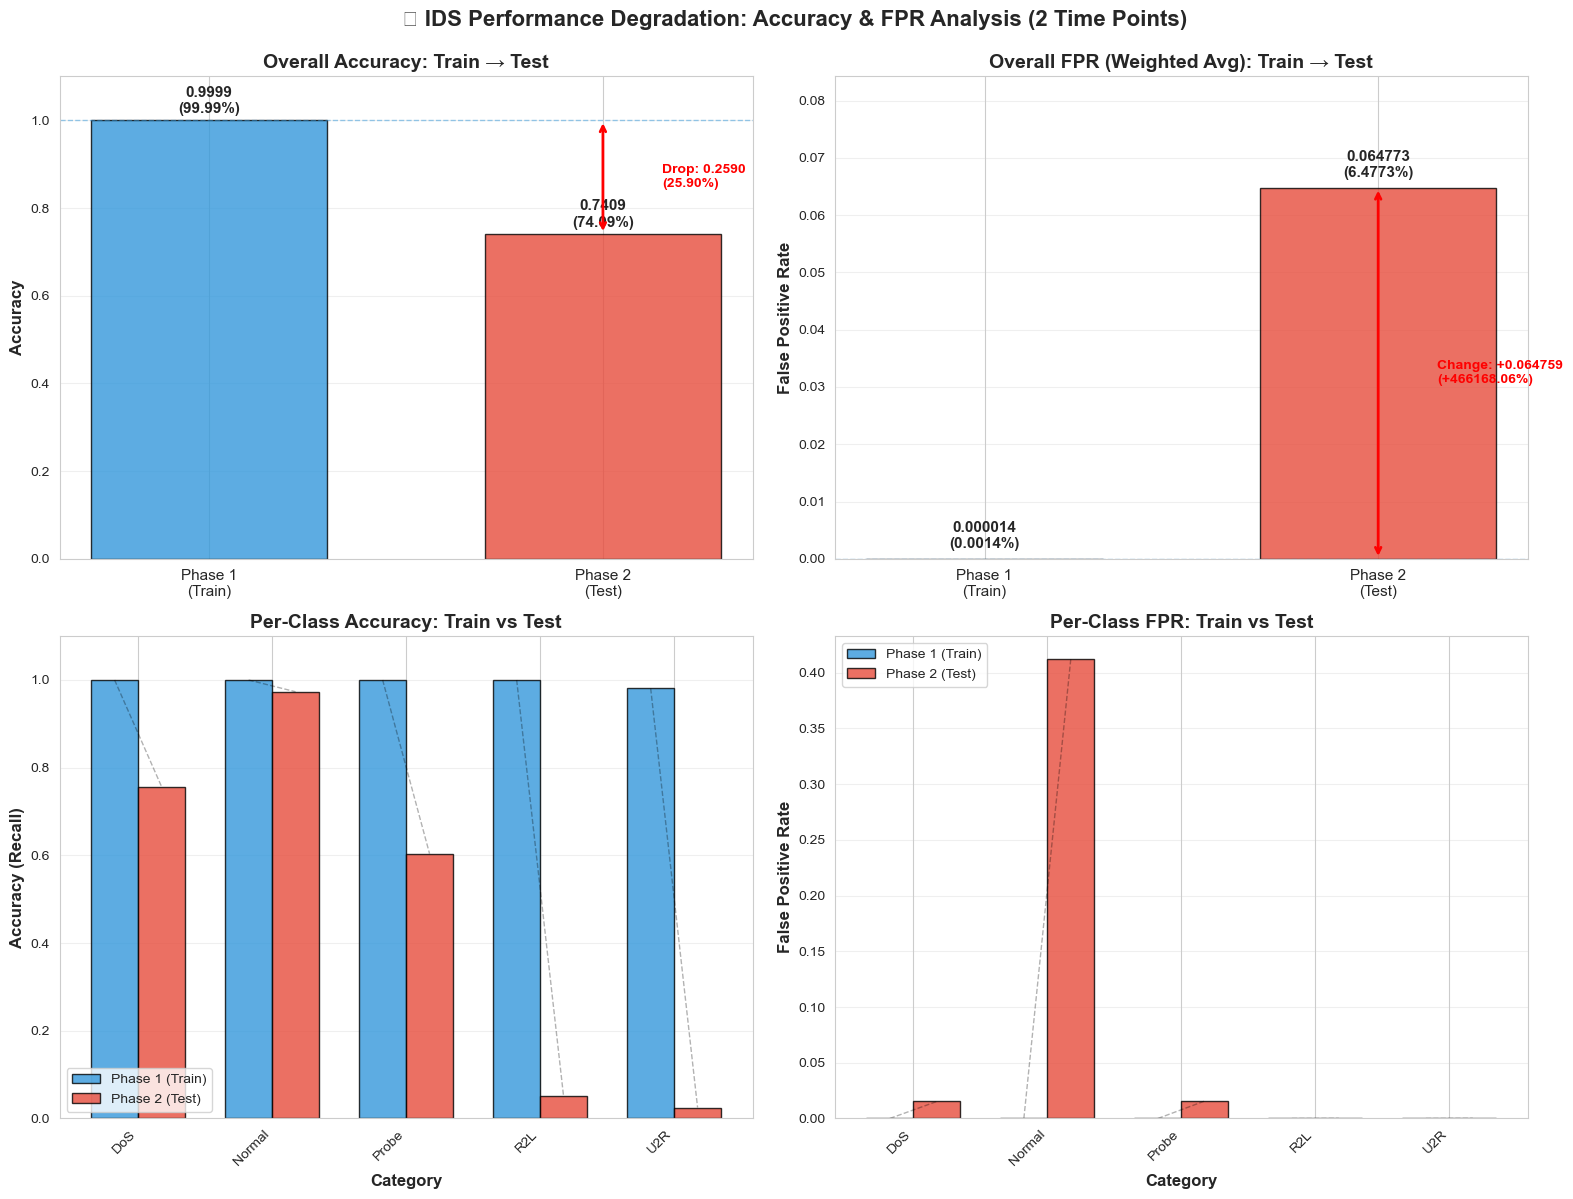

In [11]:
# Visualization: Accuracy & FPR over 2 Time Points (Train → Test)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time points
time_points = ['Phase 1\n(Train)', 'Phase 2\n(Test)']
x_pos = np.arange(len(time_points))

# ============================================================================
# Plot 1: Overall Accuracy over Time
# ============================================================================
ax = axes[0, 0]
accuracy_values = [train_accuracy, test_accuracy]
colors = ['#3498db', '#e74c3c']
bars = ax.bar(x_pos, accuracy_values, color=colors, alpha=0.8, edgecolor='black', width=0.6)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, accuracy_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.4f}\n({val*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add drop annotation
ax.annotate('', xy=(1, test_accuracy), xytext=(1, train_accuracy),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(1.15, (train_accuracy + test_accuracy)/2, 
        f'Drop: {accuracy_drop:.4f}\n({accuracy_drop*100:.2f}%)',
        fontsize=10, color='red', fontweight='bold', va='center')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Overall Accuracy: Train → Test', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(time_points, fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=train_accuracy, color='#3498db', linestyle='--', alpha=0.5, linewidth=1)

# ============================================================================
# Plot 2: Overall FPR over Time
# ============================================================================
ax = axes[0, 1]
fpr_values = [fpr_train_weighted, fpr_test_weighted]
bars = ax.bar(x_pos, fpr_values, color=colors, alpha=0.8, edgecolor='black', width=0.6)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, fpr_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(fpr_values)*0.02,
            f'{val:.6f}\n({val*100:.4f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add change annotation
if fpr_change_overall != 0:
    arrow_color = 'red' if fpr_change_overall > 0 else 'green'
    ax.annotate('', xy=(1, fpr_test_weighted), xytext=(1, fpr_train_weighted),
                arrowprops=dict(arrowstyle='<->', color=arrow_color, lw=2))
    ax.text(1.15, (fpr_train_weighted + fpr_test_weighted)/2, 
            f'Change: {fpr_change_overall:+.6f}\n({fpr_change_overall_pct:+.2f}%)',
            fontsize=10, color=arrow_color, fontweight='bold', va='center')

ax.set_ylabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Overall FPR (Weighted Avg): Train → Test', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(time_points, fontsize=11)
ax.set_ylim(0, max(fpr_values) * 1.3)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=fpr_train_weighted, color='#3498db', linestyle='--', alpha=0.5, linewidth=1)

# ============================================================================
# Plot 3: Per-Class Accuracy Comparison
# ============================================================================
ax = axes[1, 0]
x_classes = np.arange(len(label_encoder_y.classes_))
width = 0.35

# Calculate per-class accuracy from confusion matrices
train_acc_per_class = cm_train.diagonal() / cm_train.sum(axis=1)
test_acc_per_class = cm_test.diagonal() / cm_test.sum(axis=1)

bars1 = ax.bar(x_classes - width/2, train_acc_per_class, width, 
               label='Phase 1 (Train)', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_classes + width/2, test_acc_per_class, width, 
               label='Phase 2 (Test)', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (Recall)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Accuracy: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x_classes)
ax.set_xticklabels(label_encoder_y.classes_, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10, loc='lower left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Add connecting lines to show degradation
for i in range(len(label_encoder_y.classes_)):
    ax.plot([x_classes[i] - width/2, x_classes[i] + width/2], 
            [train_acc_per_class[i], test_acc_per_class[i]], 
            'k--', alpha=0.3, linewidth=1)

# ============================================================================
# Plot 4: Per-Class FPR Comparison
# ============================================================================
ax = axes[1, 1]

bars1 = ax.bar(x_classes - width/2, fpr_train_per_class, width, 
               label='Phase 1 (Train)', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_classes + width/2, fpr_test_per_class, width, 
               label='Phase 2 (Test)', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Per-Class FPR: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x_classes)
ax.set_xticklabels(label_encoder_y.classes_, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10, loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Add connecting lines
for i in range(len(label_encoder_y.classes_)):
    ax.plot([x_classes[i] - width/2, x_classes[i] + width/2], 
            [fpr_train_per_class[i], fpr_test_per_class[i]], 
            'k--', alpha=0.3, linewidth=1)

plt.suptitle('🚨 IDS Performance Degradation: Accuracy & FPR Analysis (2 Time Points)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('scenario01_accuracy_fpr_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: savefig('scenario01_accuracy_fpr_comparison.png')

# Export FPR data to CSV
df_fpr_degradation.to_csv('scenario01_fpr_degradation.csv', index=False)


## 8. Zero-day Attack Detection Analysis

In [12]:
# Identify zero-day attacks (from EDA analysis)
train_attacks = set(train_df['attack_type'].unique())
test_attacks = set(test_df['attack_type'].unique())
zero_day_attacks = test_attacks - train_attacks

print("="*80)
print(" ZERO-DAY ATTACK DETECTION (New Concept Drift)")
print("="*80)
print(f"\nTotal zero-day attacks in Test: {len(zero_day_attacks)}")
print(f"Zero-day attack types: {sorted(zero_day_attacks)}")

# Analyze zero-day detection performance
zero_day_mask = test_df['attack_type'].isin(zero_day_attacks)
zero_day_indices = np.where(zero_day_mask)[0]
zero_day_count = len(zero_day_indices)

print(f"\n Zero-day samples: {zero_day_count:,} ({zero_day_count/len(test_df)*100:.2f}% of Test set)")

# Get predictions for zero-day samples
y_test_zeroday = y_test[zero_day_indices]
y_pred_zeroday = y_test_pred[zero_day_indices]

# Zero-day detection metrics
zeroday_accuracy = accuracy_score(y_test_zeroday, y_pred_zeroday)
zeroday_recall = recall_score(y_test_zeroday, y_pred_zeroday, average='weighted', zero_division=0)
zeroday_f1 = f1_score(y_test_zeroday, y_pred_zeroday, average='weighted', zero_division=0)

print(f"\n ZERO-DAY DETECTION PERFORMANCE:")
print(f"Accuracy:  {zeroday_accuracy:.4f} ({zeroday_accuracy*100:.2f}%)")
print(f"Recall:    {zeroday_recall:.4f}")
print(f"F1-score:  {zeroday_f1:.4f}")

# Compare with known attacks
known_mask = ~zero_day_mask
known_indices = np.where(known_mask)[0]
y_test_known = y_test[known_indices]
y_pred_known = y_test_pred[known_indices]

known_accuracy = accuracy_score(y_test_known, y_pred_known)
print(f"\n COMPARISON:")
print(f"Known attacks accuracy:    {known_accuracy:.4f} ({known_accuracy*100:.2f}%)")
print(f"Zero-day attacks accuracy: {zeroday_accuracy:.4f} ({zeroday_accuracy*100:.2f}%)")
print(f"Performance gap:           {known_accuracy - zeroday_accuracy:+.4f} ({(known_accuracy - zeroday_accuracy)*100:+.2f}%)")

# Per zero-day attack breakdown
print(f"\n PER ZERO-DAY ATTACK BREAKDOWN:")
print("-"*80)
zeroday_breakdown = []
for attack in sorted(zero_day_attacks):
    attack_mask = test_df['attack_type'] == attack
    attack_indices = np.where(attack_mask)[0]
    attack_count = len(attack_indices)
    
    if attack_count > 0:
        y_true_attack = y_test[attack_indices]
        y_pred_attack = y_test_pred[attack_indices]
        attack_accuracy = accuracy_score(y_true_attack, y_pred_attack)
        
        # Get predicted categories
        predicted_categories = label_encoder_y.inverse_transform(y_pred_attack)
        true_category = test_df.loc[test_df['attack_type'] == attack, 'label'].iloc[0]
        
        # Count misclassifications
        misclass_counts = pd.Series(predicted_categories).value_counts().to_dict()
        
        zeroday_breakdown.append({
            'Attack': attack,
            'True Category': true_category,
            'Count': attack_count,
            'Accuracy': f"{attack_accuracy:.4f}",
            'Top Misclassified As': max(misclass_counts, key=misclass_counts.get) if misclass_counts else 'N/A'
        })

df_zeroday = pd.DataFrame(zeroday_breakdown)
print(df_zeroday.to_string(index=False))

 ZERO-DAY ATTACK DETECTION (New Concept Drift)

Total zero-day attacks in Test: 17
Zero-day attack types: ['apache2', 'httptunnel', 'mailbomb', 'mscan', 'named', 'processtable', 'ps', 'saint', 'sendmail', 'snmpgetattack', 'snmpguess', 'sqlattack', 'udpstorm', 'worm', 'xlock', 'xsnoop', 'xterm']

 Zero-day samples: 3,750 (16.63% of Test set)

 ZERO-DAY DETECTION PERFORMANCE:
Accuracy:  0.1088 (10.88%)
Recall:    0.1088
F1-score:  0.1737

 COMPARISON:
Known attacks accuracy:    0.8670 (86.70%)
Zero-day attacks accuracy: 0.1088 (10.88%)
Performance gap:           +0.7582 (+75.82%)

 PER ZERO-DAY ATTACK BREAKDOWN:
--------------------------------------------------------------------------------
       Attack True Category  Count Accuracy Top Misclassified As
      apache2           DoS    737   0.0665               Normal
   httptunnel           U2R    133   0.0000               Normal
     mailbomb           DoS    293   0.0000               Normal
        mscan         Probe    996   0.04

## 9. Visualization - Confusion Matrices

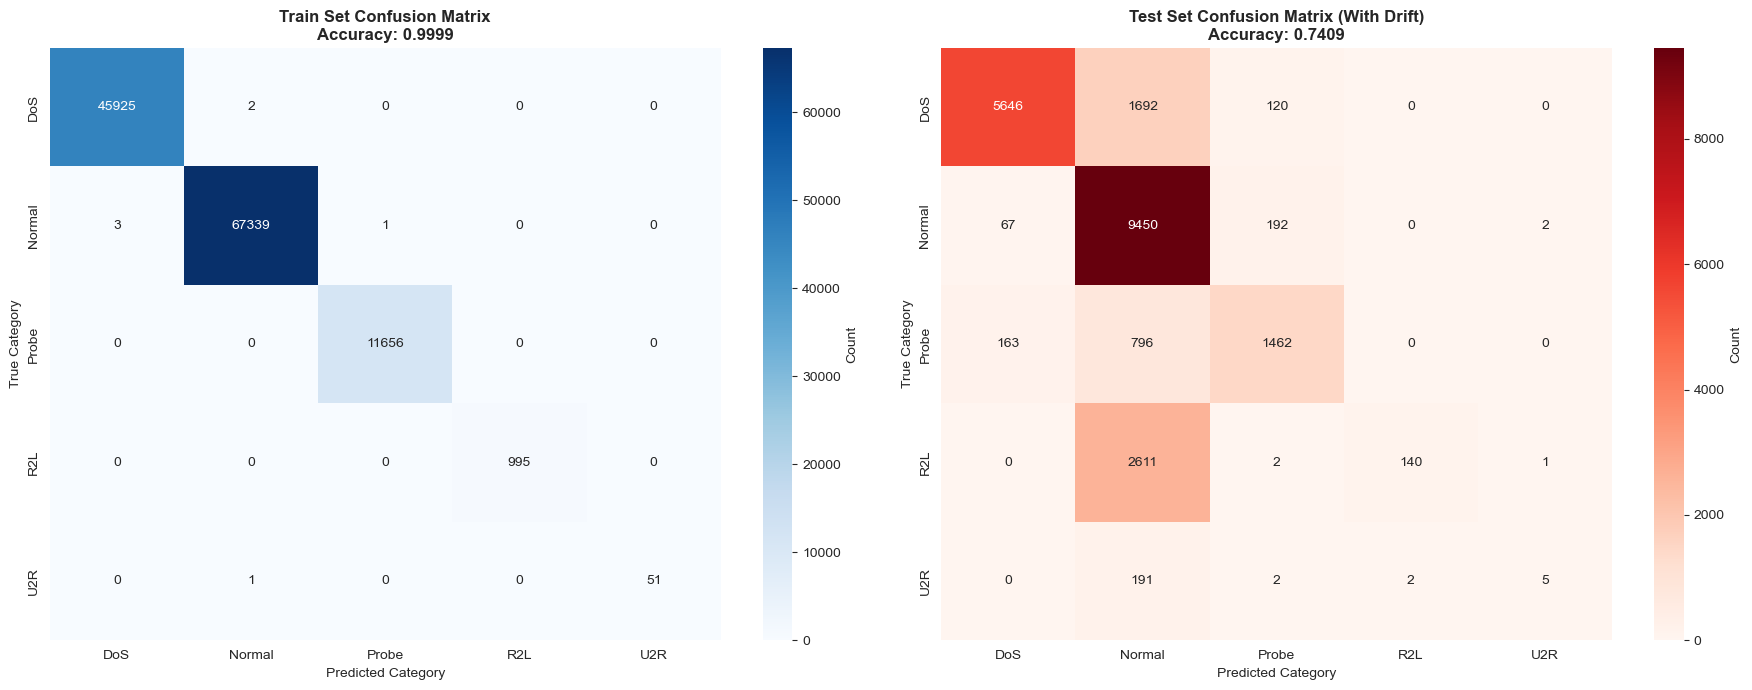

In [13]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Train confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder_y.classes_,
            yticklabels=label_encoder_y.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Train Set Confusion Matrix\nAccuracy: {train_accuracy:.4f}', 
                  fontweight='bold', fontsize=12)
axes[0].set_xlabel('Predicted Category', fontsize=10)
axes[0].set_ylabel('True Category', fontsize=10)

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', 
            xticklabels=label_encoder_y.classes_,
            yticklabels=label_encoder_y.classes_,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Test Set Confusion Matrix (With Drift)\nAccuracy: {test_accuracy:.4f}', 
                  fontweight='bold', fontsize=12)
axes[1].set_xlabel('Predicted Category', fontsize=10)
axes[1].set_ylabel('True Category', fontsize=10)

plt.tight_layout()
plt.savefig('scenario01_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()



## 10. Visualization - Per-Class Performance Comparison

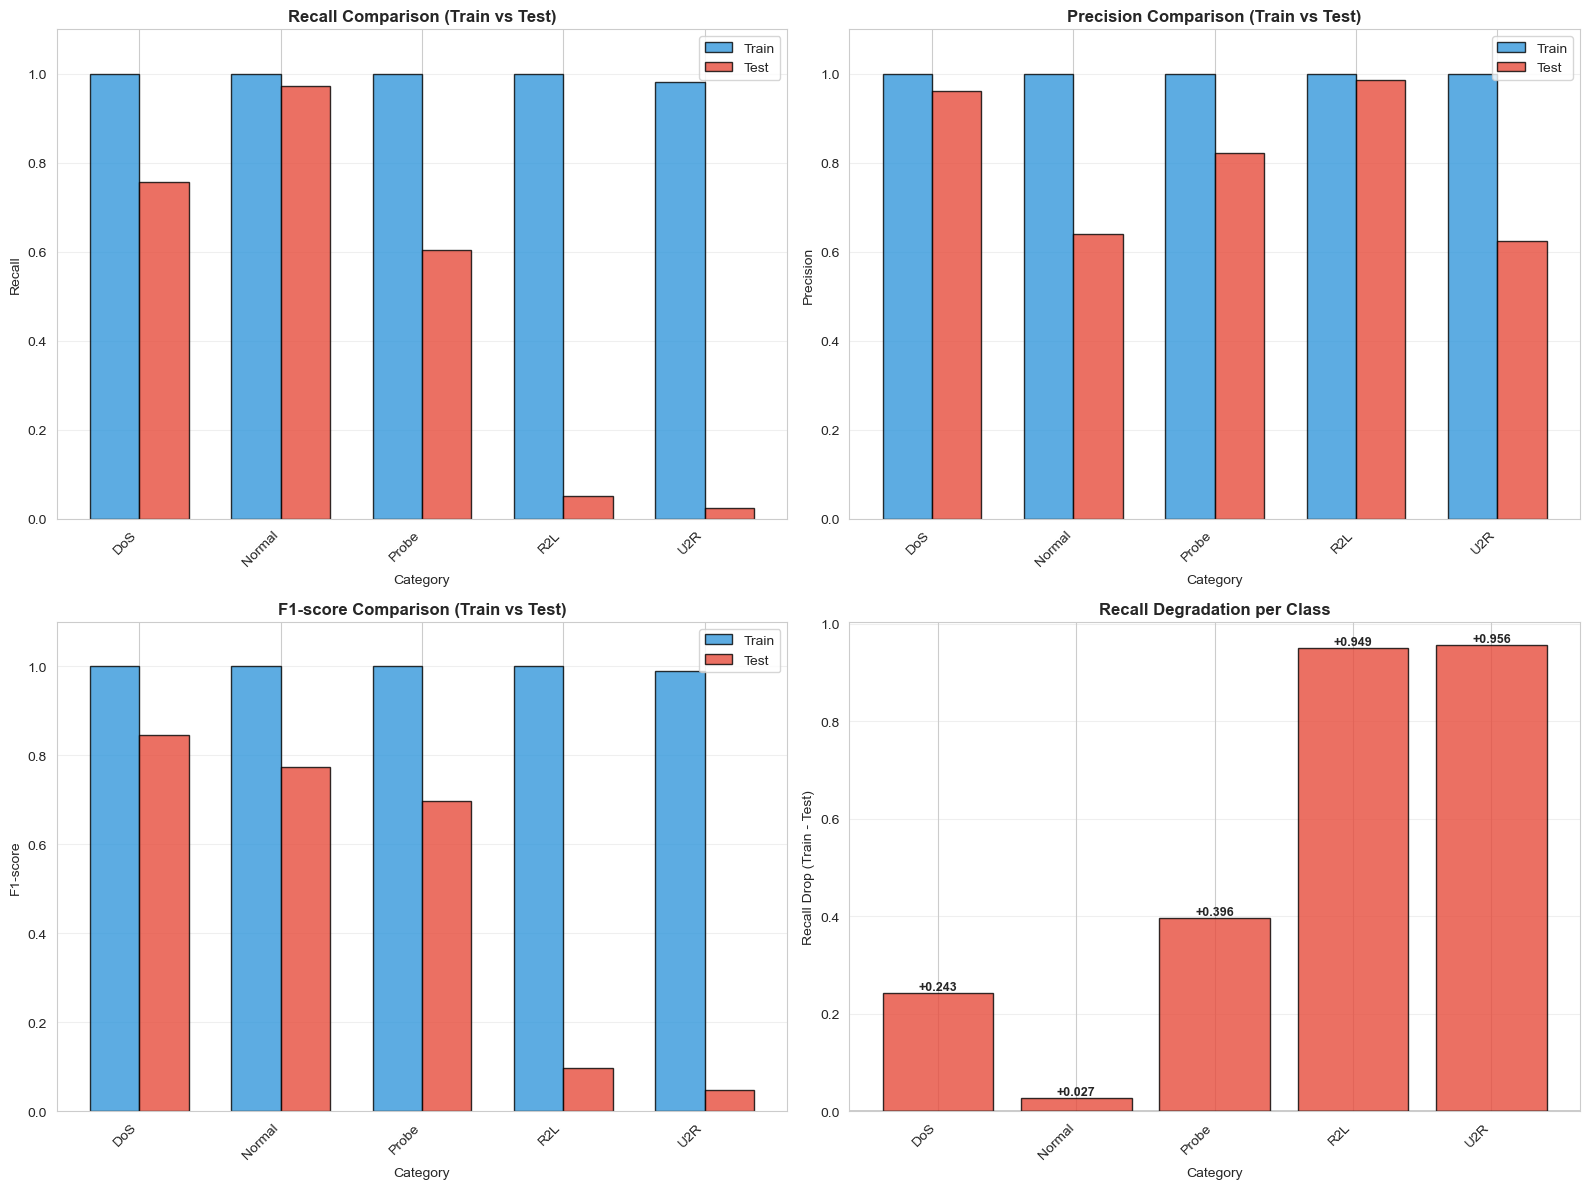

In [14]:
# Per-class Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = [
    ('Recall', train_recall_per_class, test_recall_per_class),
    ('Precision', train_precision_per_class, test_precision_per_class),
    ('F1-score', train_f1_per_class, test_f1_per_class)
]

# Plot 1: Recall comparison
ax = axes[0, 0]
x = np.arange(len(label_encoder_y.classes_))
width = 0.35
bars1 = ax.bar(x - width/2, train_recall_per_class, width, label='Train', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_recall_per_class, width, label='Test', 
               color='#e74c3c', alpha=0.8, edgecolor='black')
ax.set_xlabel('Category', fontsize=10)
ax.set_ylabel('Recall', fontsize=10)
ax.set_title('Recall Comparison (Train vs Test)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder_y.classes_, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Plot 2: Precision comparison
ax = axes[0, 1]
bars1 = ax.bar(x - width/2, train_precision_per_class, width, label='Train', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_precision_per_class, width, label='Test', 
               color='#e74c3c', alpha=0.8, edgecolor='black')
ax.set_xlabel('Category', fontsize=10)
ax.set_ylabel('Precision', fontsize=10)
ax.set_title('Precision Comparison (Train vs Test)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder_y.classes_, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Plot 3: F1-score comparison
ax = axes[1, 0]
bars1 = ax.bar(x - width/2, train_f1_per_class, width, label='Train', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_f1_per_class, width, label='Test', 
               color='#e74c3c', alpha=0.8, edgecolor='black')
ax.set_xlabel('Category', fontsize=10)
ax.set_ylabel('F1-score', fontsize=10)
ax.set_title('F1-score Comparison (Train vs Test)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder_y.classes_, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Plot 4: Performance Drop (Recall)
ax = axes[1, 1]
recall_drops_plot = train_recall_per_class - test_recall_per_class
colors = ['#27ae60' if d <= 0 else '#e74c3c' for d in recall_drops_plot]
bars = ax.bar(x, recall_drops_plot, color=colors, alpha=0.8, edgecolor='black')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Category', fontsize=10)
ax.set_ylabel('Recall Drop (Train - Test)', fontsize=10)
ax.set_title('Recall Degradation per Class', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder_y.classes_, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, recall_drops_plot)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:+.3f}',
            ha='center', va='bottom' if val > 0 else 'top',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('scenario01_per_class_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



## 11. (Removed: Feature importance — see checklist)

In [15]:
# Feature importance section removed for cleaner notebook (see checklist).
# Optional: run rf_model.feature_importances_ and plot elsewhere if needed.
df_importance = None  # placeholder so export cell does not break

## 12. Export Results

In [16]:
# Export: one summary CSV
results_summary = {
    'Train_Accuracy': train_accuracy, 'Test_Accuracy': test_accuracy,
    'Accuracy_Relative_Drop_Percent': accuracy_relative_drop,
    'Train_F1': train_f1, 'Test_F1': test_f1,
    'Worst_Class': worst_class, 'Worst_Recall_Drop': worst_drop,
    'Zero_Day_Count': zero_day_count, 'Zero_Day_Types': len(zero_day_attacks),
}
df_summary = pd.DataFrame([results_summary])
df_summary.to_csv('scenario01_results_summary.csv', index=False)
print("Saved: scenario01_results_summary.csv")

Saved: scenario01_results_summary.csv


## 13. Summary & Conclusions

In [17]:
# Summary
print("Summary: Static IDS shows clear degradation under concept drift.")
print(f"  Train accuracy {train_accuracy*100:.2f}% -> Test {test_accuracy*100:.2f}% (relative drop {accuracy_relative_drop:.2f}%).")
print(f"  Worst affected class: {worst_class} (recall drop {worst_drop*100:.2f}%).")
print(f"  Zero-day: {len(zero_day_attacks)} attack types, {zero_day_count} samples.")
print("Conclusion: Adaptive or continual learning (e.g. Scenario 02) needed for drift.")


Summary: Static IDS shows clear degradation under concept drift.
  Train accuracy 99.99% -> Test 74.09% (relative drop 25.91%).
  Worst affected class: U2R (recall drop 95.58%).
  Zero-day: 17 attack types, 3750 samples.
Conclusion: Adaptive or continual learning (e.g. Scenario 02) needed for drift.
